# FLIGHT DELAY PREDICTION

#### Import libraries and data

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix, classification_report, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
#from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

plt.style.use('seaborn-white')
%matplotlib inline

In [3]:
data20 = pd.read_csv('Jan_2020_ontime.csv')
data20.drop(['Unnamed: 21'], axis=1, inplace=True) # We will just drop this empty column
data20.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,1,3,EV,20366,EV,N48901,4397,13930,1393007,ORD,...,1197705,GRB,1003.0,0.0,1000-1059,1117.0,0.0,0.0,0.0,174.0
1,1,3,EV,20366,EV,N16976,4401,15370,1537002,TUL,...,1393007,ORD,1027.0,0.0,1000-1059,1216.0,0.0,0.0,0.0,585.0
2,1,3,EV,20366,EV,N12167,4404,11618,1161802,EWR,...,1541205,TYS,1848.0,0.0,1800-1859,2120.0,0.0,0.0,0.0,631.0
3,1,3,EV,20366,EV,N14902,4405,10781,1078105,BTR,...,1226603,IAH,1846.0,0.0,1800-1859,2004.0,0.0,0.0,0.0,253.0
4,1,3,EV,20366,EV,N606UX,4407,14524,1452401,RIC,...,1226603,IAH,1038.0,0.0,1000-1059,1330.0,0.0,0.0,0.0,1157.0


In [4]:
data19 = pd.read_csv('Jan_2019_ontime.csv')
data19.drop(['Unnamed: 21'], axis=1, inplace=True) # We will just drop this empty column

This dataset consists of two datasets, one from January 2019 and another from January 2020. We are going to concatenate them into one dataset.

In [5]:
data = pd.concat([data19, data20])

In [6]:
data.shape

(1191331, 21)

We can safely remove features consisting ID's as they don't add any info to the model. We will keep "OP_UNIQUE_CARRIER" to investigate if it adds any info to the model.

In [7]:
data.drop(['OP_CARRIER_AIRLINE_ID', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'TAIL_NUM', 'OP_UNIQUE_CARRIER'], axis=1, inplace=True)

In [8]:
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,1,2,9E,GNV,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0
1,1,2,9E,MSP,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0
2,1,2,9E,DTW,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0
3,1,2,9E,TLH,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0
4,1,2,9E,ATL,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0


We are going to remove "DEP_TIME" as it is the same information we have in "DEP_TIME_BLK". We are also going to convert our "ARR_TIME" to categorical/ordinal values, just like "DEP_TIME_BLK" is.

In [9]:
data.drop(['DEP_TIME'], axis=1, inplace=True)

Lets check how many missing values there are and if they cause any problem.

In [10]:
nans_lst = []
for column in data.columns.values:  
    nans_lst.append(data[column].isna().sum())
nans = pd.DataFrame({'Columns': data.columns, 'Nan_count': nans_lst})
nans['Pct_of_dataset'] = nans['Nan_count']/data.shape[0]*100
nans

,Columns,Nan_count,Pct_of_dataset
0,DAY_OF_MONTH,0,0.000000
1,DAY_OF_WEEK,0,0.000000
2,OP_CARRIER,0,0.000000
3,ORIGIN,0,0.000000
4,DEST,0,0.000000
5,DEP_DEL15,23054,1.935146
6,DEP_TIME_BLK,0,0.000000
7,ARR_TIME,24136,2.025969
8,ARR_DEL15,26100,2.190827
9,CANCELLED,0,0.000000


As we can see there are three features with missing data. Each of them only have about 2% of missing data, so normally it won't be a problem just to remove all the datapoints with missing data.
BUT if we take a closer look at the rows with missing values, there appears to be some correlation with "CANCELLED" and "DIVERTED". As you can see there are a large amount of NaN's when each of these two features are positive, meaning if the planes were cancelled og diverted we don't have any data in our target column "ARR_DEL15" and there are a lot of NaN's in "ARR-TIME" as well.

We could argue that if the plane was cancelled or diverted it certainly was delayed. In the end the client should decide if they want the target column to include thoses cancelled and diverted flights og if they only want flights that were delayed. But as we don't have a client, in this case we will include the cancelled and diverted flights.

We also need to fix the missing values in "ARR_TIME". For now we will add a value of "MIA" (Missing In Action). Later on we will actually remove it again, but we can do that without deleting all the involved rows.

In [11]:
#data[data['CANCELLED']==1].iloc[:,13:-1].head(10)
#data[data['DIVERTED']==1].iloc[:,13:-1].head(10)

First we are going to create our target column "y", which will contain all flights that were more than 15 min. delayed, cancelled og diverted flights.

In [12]:
data2 = data.loc[:,'ARR_DEL15':'DIVERTED']
data['y'] = np.where(np.sum(data2.T)!=0, 1, 0)
data['DEP_DEL15'] = data.apply(lambda row: 1 if row['CANCELLED']==1 else row['DEP_DEL15'], axis=1)
data['DEP_DEL15'] = data.apply(lambda row: 0 if ((np.isnan(row['DEP_DEL15'])) & (row['DIVERTED']==1)) else row['DEP_DEL15'], axis=1)

Before we replace the NaN's in "ARR_TIME" with "MIA" we need to convert the existing data in the column to time blocks, which will be earsier to handle and lower the computation time.

In [13]:
data['ARR_TIME'].head()

0     722.0
1    1633.0
2    1329.0
3    1625.0
4    1940.0
Name: ARR_TIME, dtype: float64

In [14]:
def time_blocks(df):
    arr_time_blk = []
    for i, row in df.iterrows():
        if row['CANCELLED']==1 or row['DIVERTED']==1:
            arr_time_blk.append("MIA")
        elif np.isnan(row['ARR_TIME']):
            arr_time_blk.append(None)
        elif row['ARR_TIME'] == 2400:
            arr_time_blk.append('22-24')
        elif int(row['ARR_TIME']/100)%2==1:
            arr_time_blk.append(f"{str(int(row['ARR_TIME']/100)-1).zfill(2)}-{str(int(row['ARR_TIME']/100)+1).zfill(2)}")
        else:
            arr_time_blk.append(f"{str(int(row['ARR_TIME']/100)).zfill(2)}-{str(int(row['ARR_TIME']/100)+2).zfill(2)}")
        
    return arr_time_blk

In [15]:
data['ARR_TIME_BLK'] = time_blocks(data)

In [16]:
data['ARR_TIME_BLK'].unique()

array(['06-08', '16-18', '12-14', '18-20', '08-10', '22-24', '14-16',
       '10-12', '00-02', '20-22', 'MIA', '04-06', '02-04'], dtype=object)

So we got the ARR_TIME converted into nice chunks of two hours each. Now we need to look at how the columns are interpreteted in numeric og category.

In [17]:
data.drop(['ARR_TIME', 'CANCELLED', 'DIVERTED', 'ARR_DEL15'], axis=1, inplace=True)
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,DISTANCE,y,ARR_TIME_BLK
0,1,2,9E,GNV,ATL,0.0,0600-0659,300.0,0,06-08
1,1,2,9E,MSP,CVG,0.0,1400-1459,596.0,0,16-18
2,1,2,9E,DTW,CVG,0.0,1200-1259,229.0,0,12-14
3,1,2,9E,TLH,ATL,0.0,1500-1559,223.0,0,16-18
4,1,2,9E,ATL,FSM,0.0,1900-1959,579.0,0,18-20


#### TEST FOR MISSING VALUES IN DATASET

In [18]:
nans_lst = []
for column in data.columns.values:  
    nans_lst.append(data[column].isna().sum())
nans = pd.DataFrame({'Columns': data.columns, 'Nan_count': nans_lst})
nans['Pct_of_dataset'] = nans['Nan_count']/data.shape[0]*100
nans

,Columns,Nan_count,Pct_of_dataset
0,DAY_OF_MONTH,0,0.0
1,DAY_OF_WEEK,0,0.0
2,OP_CARRIER,0,0.0
3,ORIGIN,0,0.0
4,DEST,0,0.0
5,DEP_DEL15,0,0.0
6,DEP_TIME_BLK,0,0.0
7,DISTANCE,0,0.0
8,y,0,0.0
9,ARR_TIME_BLK,0,0.0


Now that all the data have been cleaned we need to define which columns are categories and which are numeric.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191331 entries, 0 to 607345
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DAY_OF_MONTH  1191331 non-null  int64  
 1   DAY_OF_WEEK   1191331 non-null  int64  
 2   OP_CARRIER    1191331 non-null  object 
 3   ORIGIN        1191331 non-null  object 
 4   DEST          1191331 non-null  object 
 5   DEP_DEL15     1191331 non-null  float64
 6   DEP_TIME_BLK  1191331 non-null  object 
 7   DISTANCE      1191331 non-null  float64
 8   y             1191331 non-null  int32  
 9   ARR_TIME_BLK  1191331 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 95.4+ MB


As "DEP_DEL15" and our target "y" both are binary(category) we need to convert them. Rest of the columns are of the correct type.

In [20]:
cols = data.columns.tolist()
cols = cols[:-2]+cols[-1:]+cols[-2:-1]
data = data[cols]
data.iloc[:,2:-1] = data.iloc[:,2:-1].apply(lambda x: x.astype('category'))

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191331 entries, 0 to 607345
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   DAY_OF_MONTH  1191331 non-null  int64   
 1   DAY_OF_WEEK   1191331 non-null  int64   
 2   OP_CARRIER    1191331 non-null  category
 3   ORIGIN        1191331 non-null  category
 4   DEST          1191331 non-null  category
 5   DEP_DEL15     1191331 non-null  category
 6   DEP_TIME_BLK  1191331 non-null  category
 7   DISTANCE      1191331 non-null  category
 8   ARR_TIME_BLK  1191331 non-null  category
 9   y             1191331 non-null  int32   
dtypes: category(7), int32(1), int64(2)
memory usage: 43.2 MB


### Check for imbalanced target label

THERE ARE 17.93 % IN THE POSITIVE CLASS AND 82.07 % IN THE NEGATIVE CLASS


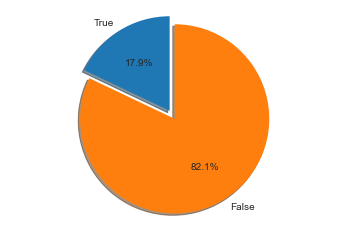

In [66]:
balance = data['y'].sum()/data.shape[0]
print(f"THERE ARE {balance*100:.2f} % IN THE POSITIVE CLASS AND {(1-balance)*100:.2f} % IN THE NEGATIVE CLASS")
hist_data = [balance, 1-balance]
labels = 'True', 'False'
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(hist_data, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('img/imbalance.png')
plt.show()

As we can see there's a big imbalance between the two classes, so we have to use AUC, Under the Curve as a metric as it can handle unbalanced datasets.

## Exploratory analysis
According to the data provider the weekdays in this dataset starts with monday (Monday = 1). If we calculate delays related to weekdays we see that\
Thursday is the day with the higest probability of delays occuring, with a 18% risk.

In [22]:
week = data[['DAY_OF_WEEK','y']].groupby('DAY_OF_WEEK').sum().sort_values(by='y',ascending=False)
week['PERCENTUAL'] = week['y']/(week['y'].sum())*100

In [23]:
print(week)

                 y  PERCENTUAL
DAY_OF_WEEK                   
4            38001   17.790147
5            34856   16.317817
3            31574   14.781351
1            28604   13.390947
6            27248   12.756136
7            27083   12.678892
2            26241   12.284710


In [24]:
weekdays = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
labels = []
for day in week.index.values.astype(int):
    labels.append(weekdays[day])

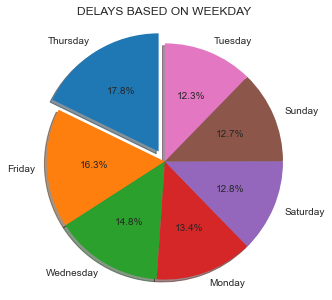

In [25]:
explode = (0.1, 0, 0, 0, 0, 0, 0)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_title('DELAYS BASED ON WEEKDAY')
ax1.pie(week['PERCENTUAL'], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('img/weekday_delays.png')
plt.show()

In [185]:
def statistics(df, column_label):
    new_df = df[[column_label,'y']].groupby(column_label).sum()
    new_df['data'] = df[column_label].value_counts().sort_index()
    new_df['PERCENTUAL'] = new_df['y']/new_df['data']*100
    new_df['MEAN'] = sum(new_df['y'])/sum(new_df['data'])*100
    new_df.reset_index(inplace=True)
    max_day = new_df['PERCENTUAL'].max()
    min_day = new_df['PERCENTUAL'].min()
    
    return new_df

DATE WITH MOST DELAYS IS THE 18th WITH 25 % OF IT'S FLIGHTS DELAYED
DATE WITH LEAST DELAYS IS THE 9th,  WITH 10 % OF IT'S FLIGHTS DELAYED


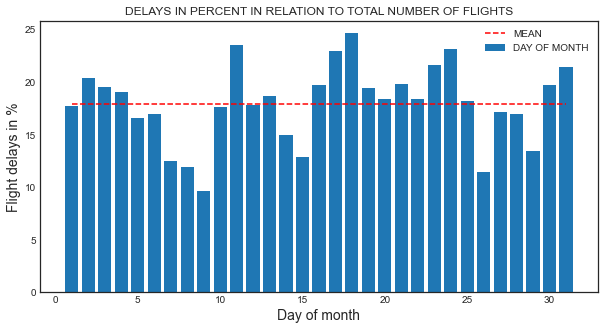

In [173]:
df = statistics(data, 'DAY_OF_MONTH')

print(f"DATE WITH MOST DELAYS IS THE {df.loc[df['PERCENTUAL']==max_day].iloc[0,0]}th WITH {max_day:.0f} % OF IT'S FLIGHTS DELAYED")
print(f"DATE WITH LEAST DELAYS IS THE {df.loc[df['PERCENTUAL']==min_day].iloc[0,0]}th,  WITH {min_day:.0f} % OF IT'S FLIGHTS DELAYED")
fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.set_title('DELAYS IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
ax2.bar(df['DAY_OF_MONTH'], df['PERCENTUAL'], label='DAY OF MONTH')
ax2.plot(df['DAY_OF_MONTH'], df['MEAN'], color='r', linestyle='--', label='MEAN')
ax2.set_xlabel('Day of month', fontsize = 14)
ax2.set_ylabel('Flight delays in %', fontsize = 14)
plt.legend()

plt.savefig('img/day_of_month_delays.png')
plt.show()

__When we look at delays in relation to day of month, there isn't a very clear trend. But there is quite a difference between the highest and lowest. But as we only have data from two months we can't conclude much__

DATE WITH MOST DELAYS IS THE MQth WITH 26 % OF IT'S FLIGHTS DELAYED
DATE WITH LEAST DELAYS IS THE HAth,  WITH 11 % OF IT'S FLIGHTS DELAYED
PERCENT OF FLIGHTS DELAYED PR. CARRIER
   OP_CARRIER  TOTAL_FLIGHTS  PERCENTUAL
9          MQ          51899   26.451377
5          EV          23759   24.437055
7          G4          14537   23.705029
3          B6          49152   22.867839
12         OO         136086   21.700248
2          AS          41854   20.944235
11         OH          47478   20.537933
6          F9          22114   20.208917
15         YV          36182   20.197888
16         YX          54878   19.634462
1          AA         153293   17.976033
13         UA          95316   17.375887
0          9E          43266   16.220589
10         NK          32699   15.517294
14         WN         221082   14.732543
4          DL         153903   11.977674
8          HA          13833   11.364129
MEAN: 17.930113461330226


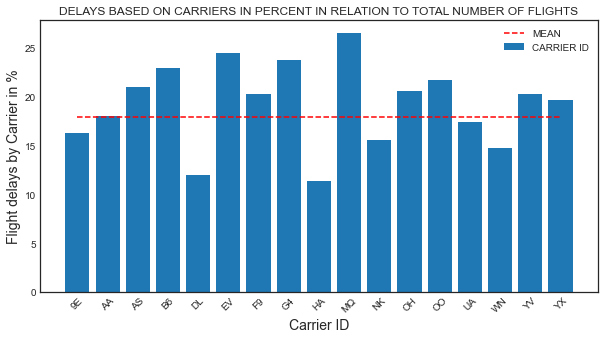

In [175]:
df = statistics(data, 'OP_CARRIER')
print(f"DATE WITH MOST DELAYS IS THE {df.loc[df['PERCENTUAL']==max_day].iloc[0,0]}th WITH {max_day:.0f} % OF IT'S FLIGHTS DELAYED")
print(f"DATE WITH LEAST DELAYS IS THE {df.loc[df['PERCENTUAL']==min_day].iloc[0,0]}th,  WITH {min_day:.0f} % OF IT'S FLIGHTS DELAYED")

df.rename(columns={"data": "TOTAL_FLIGHTS"}, inplace=True)
print("PERCENT OF FLIGHTS DELAYED PR. CARRIER")
print(df[['OP_CARRIER','TOTAL_FLIGHTS', 'PERCENTUAL']].sort_values(by='PERCENTUAL', ascending=False))
print(f"MEAN: {df['MEAN'][0]}")
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('DELAYS BASED ON CARRIERS IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
plt.bar(np.arange(len(df)), df['PERCENTUAL'], label='CARRIER ID')
ax1.plot(df.index.values.astype(int), df['MEAN'], color='r', linestyle='--', label='MEAN')
ax1.set_xlabel('Carrier ID', fontsize = 14)
ax1.set_ylabel('Flight delays by Carrier in %', fontsize = 14)
plt.xticks(np.arange(len(df)), rotation=45)
ax1.set_xticklabels(df['OP_CARRIER'])
plt.legend()
plt.savefig('img/dcarrier_delays.png')
plt.show()

__When we look at delays in relation to carrier (company) thers quite a difference between the higeste at almost 23% delays versus the lowest with just about 11% delays.
Even though it's only based on two months of data, each carrier have a lot of flights which makes these calculations more reliable.__

DATE WITH MOST DELAYS IS THE OGSth WITH 49 % OF IT'S FLIGHTS DELAYED
DATE WITH LEAST DELAYS IS THE LWSth,  WITH 3 % OF IT'S FLIGHTS DELAYED
    ORIGIN  TOTAL_FLIGHTS  PERCENTUAL
235    OGS             73   49.315068
306    SHR             37   48.648649
17     ART             62   48.387097
18     ASE           1845   43.306233
233    OGD             17   41.176471
345    VEL            106   40.566038
220    MMH            186   40.322581
243    OTH             55   40.000000
268    PSM             53   39.622642
326    SUN            389   37.532134
73     CMX            123   36.585366
143    HGR             22   36.363636
343    UIN             68   35.294118
173    JLN            171   35.087719
216    MKG            123   34.959350
13     ALO            113   34.513274
207    MEI            155   34.193548
246    PAE            155   34.193548
313    SLN            161   34.161491
61     CGI            132   34.090909


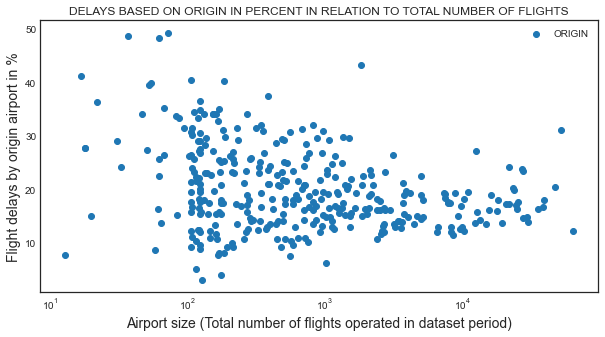

In [182]:
df = statistics(data, 'ORIGIN')

df.rename(columns={"data": "TOTAL_FLIGHTS"}, inplace=True)
print(df[['ORIGIN', 'TOTAL_FLIGHTS', 'PERCENTUAL']].sort_values(by='PERCENTUAL', ascending=False).head(20))
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('DELAYS BASED ON ORIGIN IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
plt.scatter(df['TOTAL_FLIGHTS'], df['PERCENTUAL'], label='ORIGIN')
ax1.set_xlabel('Airport size (Total number of flights operated in dataset period)', fontsize = 14)
ax1.set_ylabel('Flight delays by origin airport in %', fontsize = 14)
ax1.set_xscale('log')
plt.legend()
plt.savefig('img/origin_delays.png')
plt.show()

__There is some information we can get from the plot above. The airports with fever flights have a tendency to have more delayed flights.__

DATE WITH MOST DELAYS IS THE MKGth WITH 48 % OF IT'S FLIGHTS DELAYED
DATE WITH LEAST DELAYS IS THE BTMth,  WITH 5 % OF IT'S FLIGHTS DELAYED
    DEST  TOTAL_FLIGHTS  PERCENTUAL
216  MKG            122   47.540984
17   ART             62   46.774194
235  OGS             73   46.575342
343  UIN             68   41.176471
247  PAH            167   40.718563
88   DBQ            183   40.437158
18   ASE           1845   40.271003
243  OTH             55   40.000000
220  MMH            186   39.784946
100  EAU            123   39.024390
73   CMX            123   39.024390
345  VEL            106   38.679245
77   COU            347   38.616715
61   CGI            132   37.878788
351  YAK            120   36.666667
13   ALO            113   35.398230
281  RIW             51   35.294118
233  OGD             17   35.294118
74   CNY             83   34.939759
313  SLN            162   34.567901


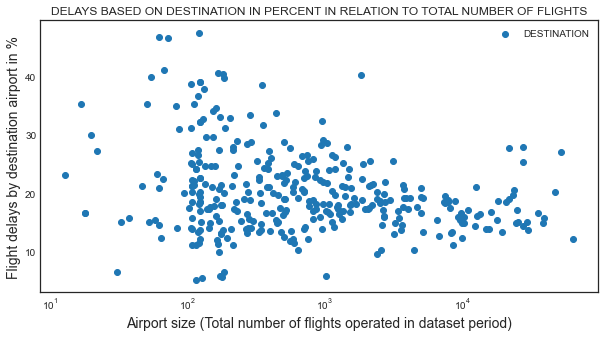

In [183]:
df = statistics(data, 'DEST')

df.rename(columns={"data": "TOTAL_FLIGHTS"}, inplace=True)
print(df[['DEST', 'TOTAL_FLIGHTS', 'PERCENTUAL']].sort_values(by='PERCENTUAL', ascending=False).head(20))
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('DELAYS BASED ON DESTINATION IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
plt.scatter(df['TOTAL_FLIGHTS'], df['PERCENTUAL'], label='DESTINATION')
ax1.set_xlabel('Airport size (Total number of flights operated in dataset period)', fontsize = 14)
ax1.set_ylabel('Flight delays by destination airport in %', fontsize = 14)
ax1.set_xscale('log')
plt.legend()
plt.savefig('img/destination_delays.png')
plt.show()

__Again, There is some information we can get from the plot above. The airports with fever flights have a tendency to have more delayed flights arriving, though the trend is less clear here than with the leaving flights.__

     DISTANCE  TOTAL_FLIGHTS  PERCENTUAL
86      186.0              1  100.000000
1124   1479.0              1  100.000000
1010   1248.0              2  100.000000
1348   2120.0              9   66.666667
992    1219.0             18   61.111111
1057   1341.0             18   50.000000
438     578.0              6   50.000000
1000   1233.0             16   50.000000
581     741.0              4   50.000000
1192   1610.0              6   50.000000
1371   2233.0              2   50.000000
261     382.0            127   48.031496
189     303.0            124   46.774194
1        45.0             94   45.744681
93      193.0            124   45.161290
927    1137.0             36   44.444444
966    1187.0             18   44.444444
554     711.0            280   44.285714
509     654.0            197   44.162437
1091   1414.0             16   43.750000


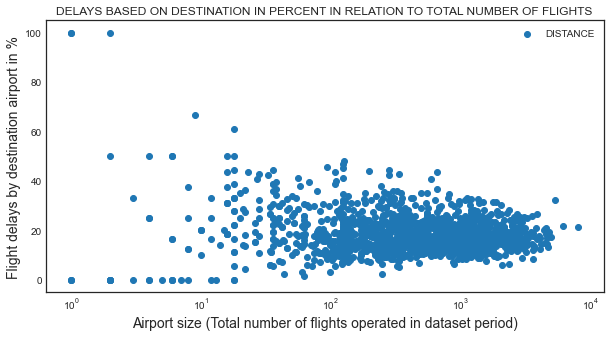

In [187]:
df = statistics(data, 'DISTANCE')

df.rename(columns={"data": "TOTAL_FLIGHTS"}, inplace=True)
print(df[['DISTANCE', 'TOTAL_FLIGHTS', 'PERCENTUAL']].sort_values(by='PERCENTUAL', ascending=False).head(20))
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('DELAYS BASED ON DESTINATION IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
plt.scatter(df['TOTAL_FLIGHTS'], df['PERCENTUAL'], label='DISTANCE')
ax1.set_xlabel('Airport size (Total number of flights operated in dataset period)', fontsize = 14)
ax1.set_ylabel('Flight delays by destination airport in %', fontsize = 14)
ax1.set_xscale('log')
plt.legend()
plt.savefig('img/destination_delays.png')
plt.show()

In [31]:
data2 = data.copy()
data2.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,DISTANCE,ARR_TIME_BLK,y
0,1,2,9E,GNV,ATL,0.0,0600-0659,300.0,06-08,0
1,1,2,9E,MSP,CVG,0.0,1400-1459,596.0,16-18,0
2,1,2,9E,DTW,CVG,0.0,1200-1259,229.0,12-14,0
3,1,2,9E,TLH,ATL,0.0,1500-1559,223.0,16-18,0
4,1,2,9E,ATL,FSM,0.0,1900-1959,579.0,18-20,0


### Functions used in training pipelines

In [71]:
#Split dataset into features and target
def X_y(df, balance=False):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    if balance:
        smote_tomek = SMOTETomek(random_state=0)
        cat = X_train.apply(lambda column: column.dtype.name=='category')
        smote_nc = SMOTENC(categorical_features=cat, random_state=0)
        X_train, y_train = smote_nc.fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test, X_val, y_val

In [36]:
def transform(df):
    all_cats = []
    for column in df.iloc[:,2:9].columns:
        all_cats.append(sorted(df[column].unique()))
    #We need to encode some of the features as categorical features in either ordinal or one-hot encoding.
    #Get unique values for ordinal encoding
    cat_columns = list(df.iloc[:,2:9].columns.values)

    dep_timeslots = sorted(data.DEP_TIME_BLK.unique().tolist()) #It is important to sort the values, otherwise it isn't ordinal and you will make it a lot harder for the model.
    arr_timeslots = sorted(data.ARR_TIME_BLK.unique().tolist())

    transformer = make_column_transformer((OrdinalEncoder(categories=[dep_timeslots]), ['DEP_TIME_BLK']), (OrdinalEncoder(categories=[arr_timeslots]), ['ARR_TIME_BLK']), (OneHotEncoder(categories=all_cats), cat_columns), (StandardScaler(), ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE']), remainder='passthrough')
    print('Tranform done!')
    return transformer

In [67]:
#Here we calculate metrics for the different algorithms and store the results in a dictionary for later comparison of the results
metrics_dict = dict()

def metrics(grid, X_test, y_test, label):
    global metrics_dict
    
    y_test_scores = grid.predict(X_test)
    lr_probs = grid.predict_proba(X_test)[:,1]
    lr_precision, lr_recall, threshold_rec = precision_recall_curve(y_test, lr_probs)
    roc_auc = roc_auc_score(y_test, lr_probs)
    fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
    
    #print(f'BEST PARAMS ARE: {grid.best_params_}')
    #print(f'SCORE: {grid.score(X_test, y_test)}')
    print(f'ROC AUC SCORE: {roc_auc_score(y_test, lr_probs):.2f}')
    print(classification_report(y_test, y_test_scores))
    
    print(f'CONFUSION MATRIX: {confusion_matrix(y_test, y_test_scores)}')
    
    #CONFUSION MATRIX PLOT
    plt.style.use('seaborn-white')
    plot_confusion_matrix(grid, X_test, y_test)
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    
    
    # Evaluating model performance at various thresholds
    df = pd.DataFrame({
                'False Positive Rate': fpr,
                'True Positive Rate': tpr
                }, index=thresholds)
    df.index.name = "Thresholds"
    df.columns.name = "Rate"

    
    #ROC AUC CURVE
    lr_fpr, lr_tpr, threshold_roc = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    ax1.plot(lr_fpr, lr_tpr, label=label, linewidth=2)
    # axis labels
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')

    #To return details about the score we can choose to return this dict as well.
    metrics_dict = {label: {'precision': lr_precision, 'recall': lr_recall, 'false_positives': lr_fpr,
                            'true_positives': lr_tpr, 'threshold_precision': threshold_rec, 'threshold_roc': threshold_roc}}
    
    #PRECISION RECALL PLOT
    ax2.plot(lr_recall, lr_precision, label='Logistic', linewidth=2)
    # axis labels
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    # show the legend
    plt.legend()
    
    # show the plot
    plt.show()
    return roc_auc, lr_precision, lr_recall

## Model training
This is a fairly simple dataset with few features, so we are just going to train models using Logistic regression and, XGBoost and RandomForest.\
For each model I have done a gridsearch over the hyperparameters to get the best fit of each model. But for practical reasons I have hardcoded the best parameters\
to  avoid running large gridsearches everytime I change something in the notebook.\
The dataset consists of many categorical features which are converted to one-hot columns and thus making the dataset very sparse and very large.\
For that reason I'm using Singular Value Decomposition (SVD) for dimensionality reduction.
First we choose wether we should oversample the dataset to make it more balanced. We choose not to do that.

In [72]:
#Should the target classes be balanced?
balance = False

#### Logistic Regression - transform, make pipeline and fit/score data

Tranform done!
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 29.3min
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed: 54.1min finished


SCORE: 0.926788833920037
ROC AUC SCORE: 0.90
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    156436
           1       0.81      0.78      0.79     34177

    accuracy                           0.93    190613
   macro avg       0.88      0.87      0.87    190613
weighted avg       0.93      0.93      0.93    190613

CONFUSION MATRIX: [[150123   6313]
 [  7642  26535]]


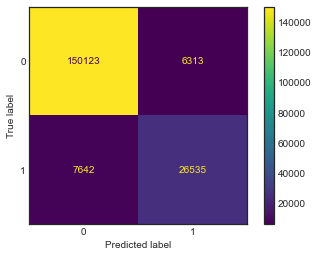

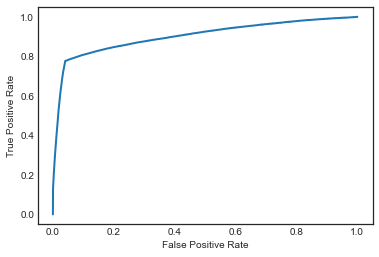

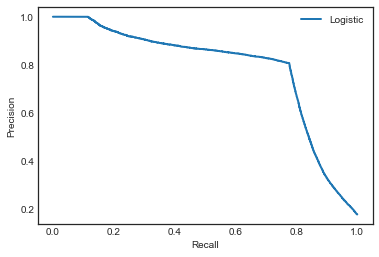

In [59]:
transformer = transform(data2)
X_train, X_test, y_train, y_test, X_val, y_val = X_y(data2, balance)

svd = TruncatedSVD()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('logistic', logistic)])
param_grid = {
    'svd__n_components': (50, 300, 50),
    'logistic__C': [.1, 1, .01],
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=8)
grid.fit(X_train, y_train)

log_roc_auc, log_precision, log_recall = metrics(grid, X_val, y_val, 'LOGISTIC')

#### XGBoost - transform, make pipeline and fit/score data

In [54]:
transformer = transform(data2.iloc[:,:-1])
X_train, X_test, y_train, y_test, X_val, y_val = X_y(data2, balance)
svd = TruncatedSVD(random_state=42)

Tranform done!


#### XGBoost gridesearch

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=42, tree_method='gpu_hist', gpu_id=0, predictor = 'gpu_predictor', sampling_method='gradient_based')
pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('xgb', xgb_clf)])
param_grid = {
    'svd__n_components': range(50,250,50),
    'xgb__learning_rate': [0.1, 0.05],
    'xgb__n_estimators': range(100,800,100),
    'xgb__max_depth': range(6,16,2),
    'xgb__gamma': [0],
    'xgb__subsample': [0.8,0.9],
    'xgb__colsample_bytree': [0.8,0.9],
    'xgb__reg_alpha': [0.1]
}

grid = RandomizedSearchCV(pipe, param_grid, cv=5, n_iter=20, verbose=2, n_jobs=4)
grid.fit(X_train, y_train)

In [ ]:
xgb_roc_auc, xgb_precision, xgb_recall = metrics(grid, X_val, y_val, 'xgb')

#### XGBoost without gridsearch

In [69]:
svd = TruncatedSVD(n_components=200, random_state=42)
xgb_clf = xgb.XGBClassifier(xgb__subsample= 0.8, xgb__reg_alpha=0.1, xgb__n_estimators=500, xgb__max_depth=6,
                        xgb__learning_rate=0.1, xgb__gamma = 0, xgb__colsample_bytree=0.9,
                        random_state=42, tree_method='gpu_hist', gpu_id=0, predictor = 'gpu_predictor', sampling_method='gradient_based')

pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('xgb', xgb_clf)])
pipe.fit(X_train, y_train)

C:\Users\Michael\anaconda3\envs\keras10\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { xgb__colsample_bytree, xgb__gamma, xgb__learning_rate, xgb__max_depth, xgb__n_estimators, xgb__reg_alpha, xgb__subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:46:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['0001-0559',
                                                                              '0600-0659',
                                                                              '0700-0759',
                                                                              '0800-0859',
                                                                              '0900-0959',
                                                                              '1000-1059',
                                                                              '1100-1159',
                                                                              '1200-1259',
                                                                              '1300-1359',
                   

ROC AUC SCORE: 0.94
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    156436
           1       0.75      0.82      0.78     34177

    accuracy                           0.92    190613
   macro avg       0.86      0.88      0.87    190613
weighted avg       0.92      0.92      0.92    190613

CONFUSION MATRIX: [[147319   9117]
 [  6262  27915]]


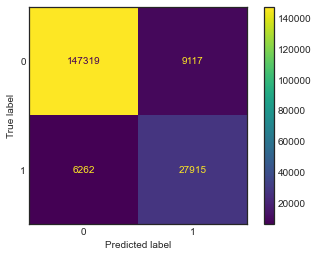

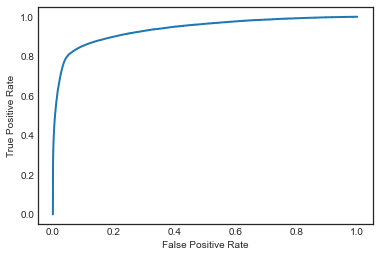

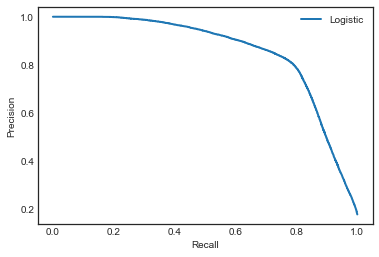

In [70]:
xgb_roc_auc, xgb_precision, xgb_recall = metrics(pipe, X_val, y_val, 'xgb')

#### RandomForest gridsearch

Tranform done!
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 232.8min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 542.8min finished


ROC AUC SCORE: 0.93
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    156436
           1       0.82      0.76      0.79     34177

    accuracy                           0.93    190613
   macro avg       0.89      0.86      0.87    190613
weighted avg       0.93      0.93      0.93    190613

CONFUSION MATRIX: [[150806   5630]
 [  8101  26076]]


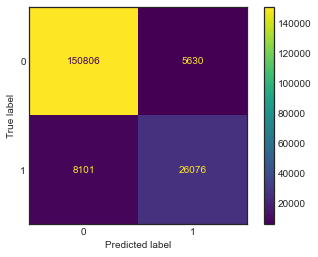

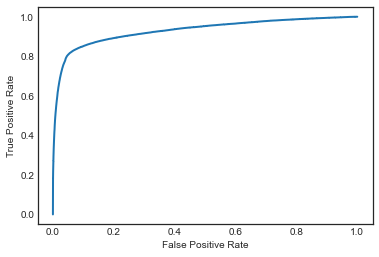

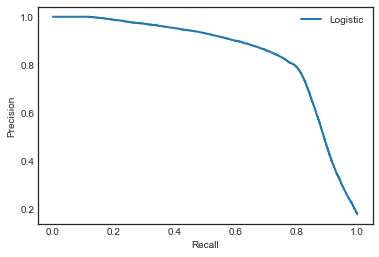

In [176]:
transformer = transform(data2)
X_train, X_test, y_train, y_test, X_val, y_val = X_y(data2, balance)

svd = TruncatedSVD()
rfc = RandomForestClassifier(random_state=42, n_jobs=8)
pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('rfc', rfc)])
param_grid = {
    'svd__n_components': range(50,700,50),
    'rfc__n_estimators': range(100,500,100),
    'rfc__max_depth': range(5,25,5),
    'rfc__criterion': ['gini','entropy'],
    'rfc__min_samples_split': [2,5],
}

grid = RandomizedSearchCV(pipe, param_grid, cv=5, n_iter=12, verbose=2, n_jobs=6)
grid.fit(X_train, y_train)

rfc_roc_auc, rfc_precision, rfc_recall = metrics(grid, X_val, y_val, 'rfc')

#### RandomForest without gridsearch

In [179]:
best_params = {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 15, 'criterion': 'entropy'}
svd = TruncatedSVD(n_components=50, random_state=42)
rfc = RandomForestClassifier(random_state=42, n_jobs=8, **best_params)

pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('rfc', rfc)])
pipe.fit(X_train, y_train)

In [180]:
rfc_roc_auc, rfc_precision, rfc_recall = metrics(grid, X_val, y_val, 'rfc')

#### Test score on choosen model
As Xgboost got the best ROC AUC score of 94, we will use this model for the final test score.

ROC AUC SCORE: 0.93
              precision    recall  f1-score   support

           0       0.95      0.96      0.95    195545
           1       0.80      0.79      0.79     42722

    accuracy                           0.93    238267
   macro avg       0.87      0.87      0.87    238267
weighted avg       0.93      0.93      0.93    238267

CONFUSION MATRIX: [[186958   8587]
 [  9117  33605]]


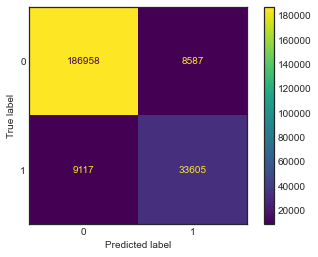

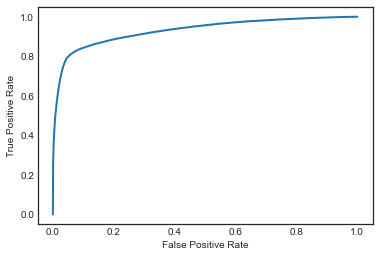

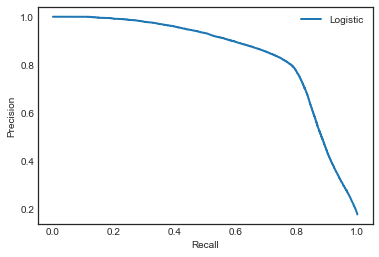

In [76]:
xgb_roc_auc, xgb_precision, xgb_recall = metrics(pipe, X_test, y_test, 'xgb')